<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/cifar_random_baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cifar_random_baselines

> Baselines: 50 and 100 epochs

In [ ]:
#| default_exp cifar_random_baselines

Setup: Surely there is a way to get rid of having to put this cell everywhere. hmmm.

Or we can just copy paste / delete this in and out when needed. Either way, getting close to a decent workable workflow.

In [1]:
#| hide
# import os
# from google.colab import drive

def colab_is_true():

    try: 
        from google.colab import drive

        return True 
    except ModuleNotFoundError:
        return False

def setup_colab():
    from google.colab import drive
    import os
    drive.mount('/content/drive',force_remount=True)
    #os.system('unzip -q "/content/drive/My Drive/archive (1).zip"')
    os.system('git clone https://github.com/hamish-haggerty/cancer-proj.git')

    os.chdir('cancer-proj')
    
    os.system('pip install .')
    os.system('pip install -qU nbdev')
    os.system('nbdev_install_quarto')

    os.system('unzip -q "/content/drive/My Drive/archive (1).zip"') #does this work?

if __name__ == "__main__":
    on_colab = colab_is_true()
    if on_colab:
        setup_colab()

Mounted at /content/drive


In [2]:
import os
os.system('pip install .')
os.system('pip install git+https://github.com/hamish-haggerty/base_rbt.git')

0

In [3]:
#| hide
from nbdev.showdoc import *

In [4]:
#| export
from fastai.vision.all import *
from base_rbt.all import *
from cancer_proj.cancer_dataloading import *
from cancer_proj.cancer_metrics import *
from cancer_proj.cancer_maintrain import *
from cancer_proj.cancer_maintrain_ensemble import *
from cancer_proj.cancer_maintrain_ce import *
from self_supervised.augmentations import assert_aug_pipelines
from self_supervised.layers import create_mlp_module

import fastai
test_eq(fastai.__version__,'2.7.11')

import torch
test_eq(torch.__version__,'1.13.1+cu116')


## Load the data

In [5]:
#hps's
device ='cuda' if torch.cuda.is_available() else 'cpu'
cuda = (device=='cuda')
n_in=3
size=32
bs=256 #for training BT
bs_val=256 #for training linear head
bs_test=100 #for evaluating linear head. Divides 10000
ts_val=256 
ts=5120


# Load prior fnames:

In [6]:
#load
directory = '/content/drive/My Drive/cifar'
main_dict = load_dict_from_gdrive(directory=directory,filename='main_dict')

In [ ]:
main_dict[0].keys()

dict_keys(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'accuracy', 'macro avg', 'weighted avg', 'acc', 'auc_dict', 'scores', 'preds', 'xval', 'yval', 'classif_model_path', 'bt_model_path', 'tune_model_path'])

In [7]:
fnames = main_dict['fnames']
fnames_train = main_dict['fnames_train']
fnames_val = main_dict['fnames_val']

In [8]:
#data: dls, dls_val, dls_test
#get the data: Need dls, dls_val, dls_test
path = untar_data(URLs.CIFAR)
#fnames = get_image_files(path / "train")
#fnames=fnames.shuffle()
# fnames_train = fnames[0:ts]
# fnames_val = fnames[ts:]

fnames_test = get_image_files(path / "test")
#fnames_test = fnames[ts+ts_val:ts+ts_val+ts_test]

def label_func(fname):
    return fname.name.split('_')[1].strip('png').strip('.')

#labels for train,eval and test
labels = [label_func(fname) for fname in fnames]
labels_train = labels[0:ts]
labels_val = labels[ts:ts+ts_val]
labels_test = [label_func(fname) for fname in fnames_test]

#Used for training encoder i.e. BT
dls_train = ImageDataLoaders.from_lists(path, fnames_train, labels_train,bs=bs, item_tfms=[Resize(size=size)], #batch_tfms=[ToTensor(), IntToFloatTensor()],
                                  valid_pct=0.0,num_workers=12,device=device)
dls_tune = dls_train

test_eq(ts_val%bs_val,0)
dls_valid = ImageDataLoaders.from_lists(path, fnames_val, labels_val,bs=bs_val, item_tfms=[Resize(size=size)], #batch_tfms=[ToTensor(), IntToFloatTensor()],
                                  valid_pct=0.0,num_workers=12,device=device,shuffle=False)

#Used for evaluating linear classifier
dls_test = ImageDataLoaders.from_lists(path, fnames_test, labels_test,bs=bs_test, item_tfms=[Resize(size=size)], #batch_tfms=[ToTensor(), IntToFloatTensor()],
                                  valid_pct=0.0,num_workers=12,device=device)

# labels = list(set(labels))
# dls_train.vocab = labels
# dls_tune.vocab = labels
# dls_valid.vocab = labels
# dls_test.vocab = labels


set(labels) #Check that the labels make sense

{'airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck'}

#Test data

In [60]:
test_dls_train = ImageDataLoaders.from_lists(path, fnames_train, labels_train,bs=1, item_tfms=[Resize(size=size)], #batch_tfms=[ToTensor(), IntToFloatTensor()],
                                  valid_pct=0.0,num_workers=12,device=device)
s=0
for x,y in test_dls_train.train:
    s+=y.sum().item()
test_eq(s,23183) #this just verifies that the sum of the labels is the same each time.

from collections import Counter
counts = Counter(labels_train)
test_eq(counts['bird'],486) #basically same test as above, but in a different way (and on labels vs on dataloader, so the test is non-redundant)
test_eq(counts['dog'],513)

test_eq(fnames[0],fnames_train[0]) 
test_eq(fnames_train[0],Path('/root/.fastai/data/cifar10/train/bird/38030_bird.png')) #Not sure if order will be preserved


## Load aug pipelines here

In [9]:
#| export

BYOL_Augs = dict(flip_p1=0.5,flip_p2=0.5,jitter_p1=0.8,jitter_p2=0.8,bw_p1=0.2,
                bw_p2=0.2,blur_p1=1.0,blur_p2=0.1,sol_p1=0.0,sol_p2=0.2,noise_p1=0.0,
                noise_p2=0.0,resize_scale=(0.7, 1.0),resize_ratio=(3/4, 4/3),rotate_deg=45.0,
                rotate_p=0.5,blur_r=(0.1,2),blur_s=13,sol_t=0.1,sol_a=0.1,noise_std=0.1
                )


TUNE_Augs=dict(blur_r = BYOL_Augs['blur_r'],blur_s = BYOL_Augs['blur_s'], flip_p=0.25,
                rotate_p=0.25,jitter_p=0.0,bw_p=0.0,blur_p=0.0,resize_scale=(0.7, 1.0),
                resize_ratio=(3/4, 4/3),rotate_deg=45.0
                )

Val_Augs = dict(TUNE_Augs)


def create_aug_pipelines(size,device,Augs=BYOL_Augs,TUNE_Augs=TUNE_Augs,Val_Augs=Val_Augs):
    "Create the BT pipelines, the tune and val pipelines"

    aug_dict = {}

    aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=size,
                        rotate=True,jitter=True,noise=True,bw=True,blur=True,solar=True, #Whether to use aug or not
                        resize_scale=Augs['resize_scale'],resize_ratio=Augs['resize_ratio'],
                        noise_std=Augs['noise_std'], rotate_deg=Augs['rotate_deg'],
                        blur_r=Augs['blur_r'],blur_s=Augs['blur_s'],sol_t=Augs['sol_t'],sol_a=Augs['sol_a'],
                        flip_p=Augs['flip_p1'], rotate_p=Augs['rotate_p'],noise_p=Augs['noise_p1'],
                        jitter_p=Augs['jitter_p1'], bw_p=Augs['bw_p1'], blur_p=Augs['blur_p1'],
                        sol_p=Augs['sol_p1'], #prob of performing aug
                        same_on_batch=False,stats=Augs['stats'], cuda=(device=='cuda'))

    aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=size,
                        rotate=True,jitter=True,noise=True,bw=True,blur=True,solar=True, #Whether to use aug or not
                        resize_scale=Augs['resize_scale'],resize_ratio=Augs['resize_ratio'],
                        noise_std=Augs['noise_std'], rotate_deg=Augs['rotate_deg'],
                        blur_r=Augs['blur_r'],blur_s=Augs['blur_s'],sol_t=Augs['sol_t'],sol_a=Augs['sol_a'],
                        flip_p=Augs['flip_p2'], rotate_p=Augs['rotate_p'],noise_p=Augs['noise_p2'],
                        jitter_p=Augs['jitter_p2'], bw_p=Augs['bw_p2'], blur_p=Augs['blur_p2'],
                        sol_p=Augs['sol_p2'], #prob of performing aug
                        same_on_batch=False,stats=Augs['stats'], cuda=(device=='cuda'))

    aug_pipelines = [aug_pipelines_1,aug_pipelines_2]


    aug_pipelines_tune =  [get_barlow_twins_aug_pipelines(size=size,
                    rotate=True,jitter=True,noise=False,bw=True,blur=True,solar=False, #Whether to use aug or not
                    resize_scale=TUNE_Augs['resize_scale'],resize_ratio=TUNE_Augs['resize_ratio'],noise_std=None,
                    blur_r=TUNE_Augs['blur_r'],blur_s=TUNE_Augs['blur_s'], rotate_deg=TUNE_Augs['rotate_deg'],
                    sol_t=None,sol_a=None, #hps of augs
                    flip_p=TUNE_Augs['flip_p'], rotate_p=TUNE_Augs['rotate_p'],noise_p=0.0, jitter_p=TUNE_Augs['jitter_p'],
                    bw_p=TUNE_Augs['bw_p'], blur_p=TUNE_Augs['blur_p'],sol_p=0.0, #prob of performing aug
                    same_on_batch=False,stats=Augs['stats'], cuda=(device=='cuda'))]#,P=0.0)




    aug_pipelines_test =  [get_barlow_twins_aug_pipelines(size=size,
                    rotate=True,jitter=True,noise=False,bw=True,blur=True,solar=False, #Whether to use aug or not
                    resize_scale=Val_Augs['resize_scale'],resize_ratio=Val_Augs['resize_ratio'],noise_std=None,
                    blur_r=Val_Augs['blur_r'],blur_s=Val_Augs['blur_s'], rotate_deg=Val_Augs['rotate_deg'],
                    sol_t=None,sol_a=None, #hps of augs
                    flip_p=Val_Augs['flip_p'], rotate_p=Val_Augs['rotate_p'],noise_p=0.0, jitter_p=Val_Augs['jitter_p'],
                    bw_p=Val_Augs['bw_p'], blur_p=Val_Augs['blur_p'],sol_p=0.0, #prob of performing aug
                    same_on_batch=False,stats=Augs['stats'], cuda=(device=='cuda'))]#,P=0.0)

    aug_dict['aug_pipelines'] = aug_pipelines
    aug_dict['aug_pipelines_tune'] = aug_pipelines_tune
    aug_dict['aug_pipelines_test'] = aug_pipelines_test

    return aug_dict



In [10]:
#| hide

_Augs = dict(BYOL_Augs)
_Augs['stats'] = cifar_stats
aug_dict = create_aug_pipelines(size=size,device=device,Augs=_Augs,TUNE_Augs=TUNE_Augs,Val_Augs=Val_Augs)
aug_pipelines = aug_dict['aug_pipelines']
aug_pipelines_tune = aug_dict['aug_pipelines_tune']
aug_pipelines_test = aug_dict['aug_pipelines_test'] 

## Optionally, display:

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 1.0, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

         [[0.4470]]]], device='cuda:0'), 'std': tensor([[[[0.2470]],

         [[0.2430]],

         [[0.2610]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.1, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([

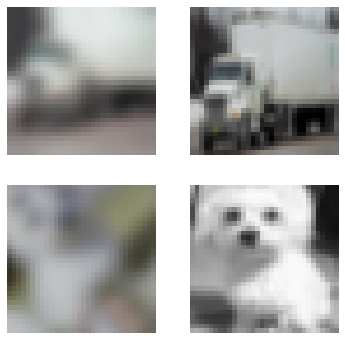

In [ ]:
#| hide
show_bt_batch(dls=dls_train,aug=aug_pipelines,n_in=3)

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.0, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

         [[0.4470]]]], device='cuda:0'), 'std': tensor([[[[0.2470]],

         [[0.2430]],

         [[0.2610]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: 


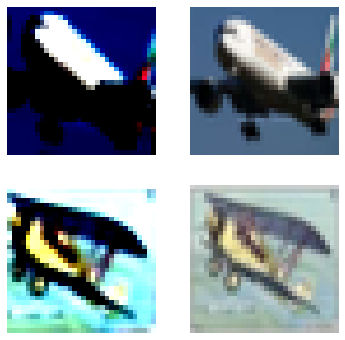

In [ ]:
#| hide

show_linear_batch(dls=dls_tune,n_in=3,aug=aug_pipelines_tune,n=2,print_augs=True)

In [ ]:
#| hide
#show_btens_batch(dls_train,3,aug_pipelines,n=2)

## Step 1) Train two BT models on CIFAR10, and save them

In [11]:
import os
directory = '/content/drive/My Drive/cifar'
if not os.path.exists(directory):
    os.makedirs(directory)

In [12]:
xval,yval = main_dict[0]['xval'], main_dict[0]['yval']

# Fine tune and predictions

In [ ]:
@patch
def before_epoch(self:LinearBt):

    if self.epoch == 50:

        #save model and results

        path=directory + f'/50_epochs_run_{self.num_i}'

        torch.save(learn.model.state_dict(),path)

        scores,preds, acc = predict_model(xval,yval,model=self.learn.model,aug_pipelines_test=aug_pipelines_test,numavg=10)

        #metrics dict will have f1 score, auc etc etc
        metrics = classification_report_wrapper(preds, yval, vocab, print_report=True)
        auc_dict = plot_roc(yval,preds,vocab,print_plot=True)
        metrics['acc'],metrics['auc_dict'],metrics['scores'],metrics['preds'],metrics['xval'],metrics['yval'] = acc,auc_dict,scores,preds,xval,yval
        metrics['model_path'] = path

        self.learn.fifty_epochs_metrics = metrics

        print(f'Acc after 50 epochs, on run {self.num_i} is: {acc}')



epoch,train_loss,valid_loss,time
0,2.534636,None,00:04
1,2.228829,None,00:04
2,2.074868,None,00:04
3,1.949898,None,00:04
4,1.865700,None,00:04
5,1.807874,None,00:04
6,1.760470,None,00:04
7,1.684406,None,00:04
8,1.612930,None,00:04
9,1.570335,None,00:04


              precision    recall  f1-score   support

    airplane       0.93      0.52      0.67        25
  automobile       0.89      0.40      0.55        20
        bird       0.48      0.44      0.46        27
         cat       0.39      0.28      0.33        25
        deer       0.26      0.33      0.29        15
         dog       0.65      0.54      0.59        28
        frog       0.57      0.53      0.55        30
       horse       0.48      0.73      0.58        30
        ship       0.70      0.91      0.79        34
       truck       0.53      0.73      0.62        22

    accuracy                           0.57       256
   macro avg       0.59      0.54      0.54       256
weighted avg       0.60      0.57      0.56       256

Acc after 50 epochs, on run 0 is: 0.56640625


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


              precision    recall  f1-score   support

    airplane       0.77      0.80      0.78        25
  automobile       0.62      0.65      0.63        20
        bird       0.55      0.41      0.47        27
         cat       0.57      0.32      0.41        25
        deer       0.19      0.47      0.27        15
         dog       0.50      0.57      0.53        28
        frog       0.54      0.47      0.50        30
       horse       0.76      0.53      0.63        30
        ship       0.75      0.97      0.85        34
       truck       0.75      0.55      0.63        22

    accuracy                           0.59       256
   macro avg       0.60      0.57      0.57       256
weighted avg       0.62      0.59      0.59       256

Acc after 50 epochs, on run 0 is: 0.5859375


epoch,train_loss,valid_loss,time
0,2.558937,None,00:04
1,2.256578,None,00:04
2,2.081282,None,00:04
3,1.960972,None,00:04
4,1.876230,None,00:04
5,1.834911,None,00:04
6,1.775769,None,00:04
7,1.690757,None,00:04
8,1.642856,None,00:04
9,1.598511,None,00:04


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


              precision    recall  f1-score   support

    airplane       0.80      0.48      0.60        25
  automobile       0.76      0.65      0.70        20
        bird       0.60      0.22      0.32        27
         cat       0.31      0.48      0.38        25
        deer       0.19      0.47      0.27        15
         dog       0.54      0.54      0.54        28
        frog       0.67      0.47      0.55        30
       horse       0.64      0.30      0.41        30
        ship       0.57      0.91      0.70        34
       truck       0.67      0.64      0.65        22

    accuracy                           0.52       256
   macro avg       0.57      0.51      0.51       256
weighted avg       0.59      0.52      0.52       256

Acc after 50 epochs, on run 1 is: 0.51953125


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


              precision    recall  f1-score   support

    airplane       0.56      0.88      0.69        25
  automobile       0.50      0.60      0.55        20
        bird       0.62      0.30      0.40        27
         cat       0.41      0.28      0.33        25
        deer       0.33      0.73      0.46        15
         dog       0.55      0.57      0.56        28
        frog       0.61      0.57      0.59        30
       horse       0.62      0.53      0.57        30
        ship       0.90      0.76      0.83        34
       truck       0.56      0.45      0.50        22

    accuracy                           0.57       256
   macro avg       0.57      0.57      0.55       256
weighted avg       0.59      0.57      0.56       256

Acc after 50 epochs, on run 1 is: 0.56640625


epoch,train_loss,valid_loss,time
0,2.560498,None,00:04
1,2.237166,None,00:04
2,2.055647,None,00:04
3,1.941539,None,00:04
4,1.876204,None,00:04
5,1.795161,None,00:04
6,1.717715,None,00:04
7,1.665693,None,00:04
8,1.642936,None,00:04
9,1.601295,None,00:04


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


              precision    recall  f1-score   support

    airplane       0.70      0.76      0.73        25
  automobile       0.54      0.65      0.59        20
        bird       0.52      0.41      0.46        27
         cat       0.27      0.48      0.35        25
        deer       0.36      0.60      0.45        15
         dog       0.62      0.46      0.53        28
        frog       0.71      0.33      0.45        30
       horse       0.60      0.60      0.60        30
        ship       0.90      0.79      0.84        34
       truck       0.65      0.59      0.62        22

    accuracy                           0.57       256
   macro avg       0.59      0.57      0.56       256
weighted avg       0.61      0.57      0.57       256

Acc after 50 epochs, on run 2 is: 0.56640625


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


              precision    recall  f1-score   support

    airplane       0.70      0.84      0.76        25
  automobile       0.65      0.55      0.59        20
        bird       0.67      0.44      0.53        27
         cat       0.47      0.64      0.54        25
        deer       0.35      0.60      0.44        15
         dog       0.60      0.54      0.57        28
        frog       0.82      0.60      0.69        30
       horse       0.83      0.63      0.72        30
        ship       0.72      0.85      0.78        34
       truck       0.62      0.59      0.60        22

    accuracy                           0.64       256
   macro avg       0.64      0.63      0.62       256
weighted avg       0.66      0.64      0.64       256

Acc after 50 epochs, on run 2 is: 0.63671875


epoch,train_loss,valid_loss,time
0,2.612907,None,00:04
1,2.235309,None,00:04
2,2.054293,None,00:04
3,1.928378,None,00:04
4,1.855732,None,00:04
5,1.783720,None,00:04
6,1.703663,None,00:04
7,1.648736,None,00:04
8,1.624065,None,00:04
9,1.589633,None,00:04


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


              precision    recall  f1-score   support

    airplane       0.67      0.48      0.56        25
  automobile       0.75      0.45      0.56        20
        bird       0.57      0.48      0.52        27
         cat       0.33      0.56      0.42        25
        deer       0.43      0.67      0.53        15
         dog       0.49      0.61      0.54        28
        frog       0.74      0.47      0.57        30
       horse       0.59      0.57      0.58        30
        ship       0.71      0.71      0.71        34
       truck       0.57      0.55      0.56        22

    accuracy                           0.55       256
   macro avg       0.58      0.55      0.55       256
weighted avg       0.59      0.55      0.56       256

Acc after 50 epochs, on run 3 is: 0.5546875


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


              precision    recall  f1-score   support

    airplane       0.65      0.80      0.71        25
  automobile       0.67      0.40      0.50        20
        bird       0.43      0.44      0.44        27
         cat       0.40      0.48      0.44        25
        deer       0.53      0.53      0.53        15
         dog       0.62      0.46      0.53        28
        frog       0.62      0.60      0.61        30
       horse       0.64      0.60      0.62        30
        ship       0.67      0.85      0.75        34
       truck       0.74      0.64      0.68        22

    accuracy                           0.59       256
   macro avg       0.60      0.58      0.58       256
weighted avg       0.60      0.59      0.59       256

Acc after 50 epochs, on run 3 is: 0.59375


epoch,train_loss,valid_loss,time
0,2.669285,None,00:04
1,2.305048,None,00:04
2,2.114704,None,00:04
3,1.976372,None,00:04
4,1.867286,None,00:04
5,1.767242,None,00:04
6,1.690592,None,00:04
7,1.615423,None,00:04
8,1.560674,None,00:04
9,1.502114,None,00:04


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


              precision    recall  f1-score   support

    airplane       0.57      0.68      0.62        25
  automobile       0.45      0.85      0.59        20
        bird       0.62      0.30      0.40        27
         cat       0.37      0.56      0.44        25
        deer       0.31      0.27      0.29        15
         dog       0.81      0.46      0.59        28
        frog       0.44      0.60      0.51        30
       horse       0.69      0.60      0.64        30
        ship       0.79      0.65      0.71        34
       truck       0.54      0.32      0.40        22

    accuracy                           0.54       256
   macro avg       0.56      0.53      0.52       256
weighted avg       0.58      0.54      0.54       256

Acc after 50 epochs, on run 4 is: 0.5390625


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


              precision    recall  f1-score   support

    airplane       0.79      0.76      0.78        25
  automobile       0.66      0.95      0.78        20
        bird       0.52      0.44      0.48        27
         cat       0.39      0.36      0.37        25
        deer       0.35      0.40      0.38        15
         dog       0.46      0.68      0.55        28
        frog       0.58      0.63      0.60        30
       horse       0.77      0.57      0.65        30
        ship       0.85      0.82      0.84        34
       truck       0.82      0.41      0.55        22

    accuracy                           0.61       256
   macro avg       0.62      0.60      0.60       256
weighted avg       0.63      0.61      0.61       256

Acc after 50 epochs, on run 4 is: 0.61328125


epoch,train_loss,valid_loss,time
0,2.569215,None,00:04
1,2.232728,None,00:04
2,2.062135,None,00:04
3,1.938062,None,00:04
4,1.839041,None,00:04
5,1.758849,None,00:04
6,1.687917,None,00:04
7,1.630256,None,00:04
8,1.564002,None,00:04
9,1.530000,None,00:04


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


              precision    recall  f1-score   support

    airplane       0.61      0.76      0.68        25
  automobile       0.43      0.65      0.52        20
        bird       0.43      0.48      0.46        27
         cat       0.50      0.28      0.36        25
        deer       0.50      0.53      0.52        15
         dog       0.56      0.68      0.61        28
        frog       0.54      0.47      0.50        30
       horse       0.74      0.57      0.64        30
        ship       0.87      0.76      0.81        34
       truck       0.45      0.45      0.45        22

    accuracy                           0.57       256
   macro avg       0.56      0.56      0.56       256
weighted avg       0.58      0.57      0.57       256

Acc after 50 epochs, on run 5 is: 0.5703125


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


              precision    recall  f1-score   support

    airplane       0.74      0.80      0.77        25
  automobile       0.59      0.65      0.62        20
        bird       0.65      0.48      0.55        27
         cat       0.45      0.40      0.43        25
        deer       0.28      0.47      0.35        15
         dog       0.39      0.64      0.49        28
        frog       0.73      0.63      0.68        30
       horse       0.70      0.47      0.56        30
        ship       0.84      0.79      0.82        34
       truck       0.62      0.45      0.53        22

    accuracy                           0.59       256
   macro avg       0.60      0.58      0.58       256
weighted avg       0.62      0.59      0.60       256

Acc after 50 epochs, on run 5 is: 0.58984375


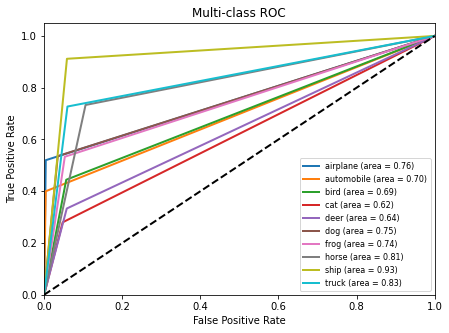

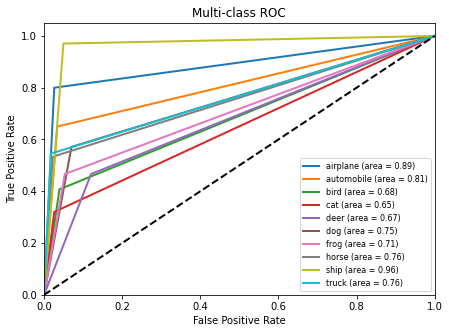

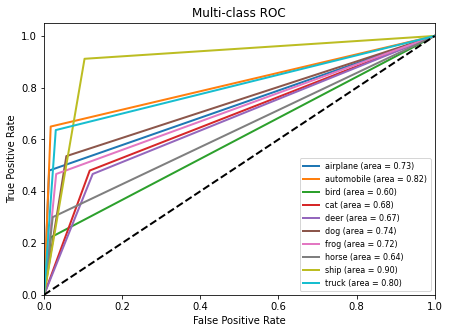

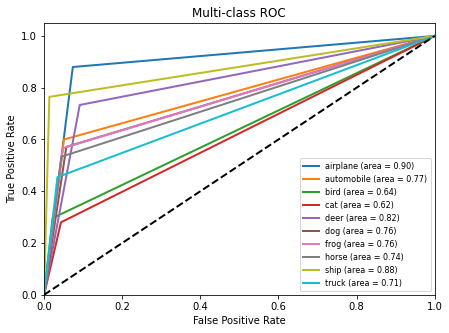

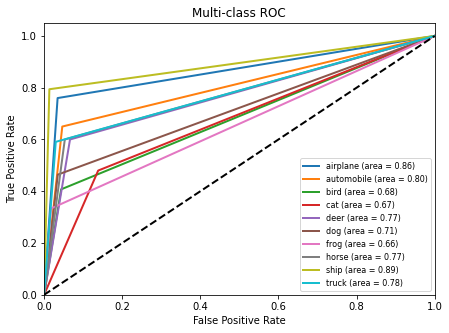

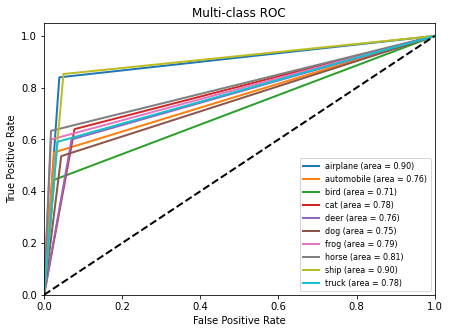

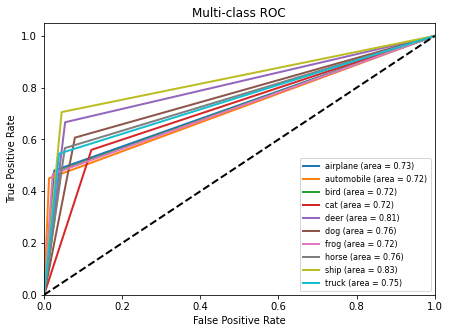

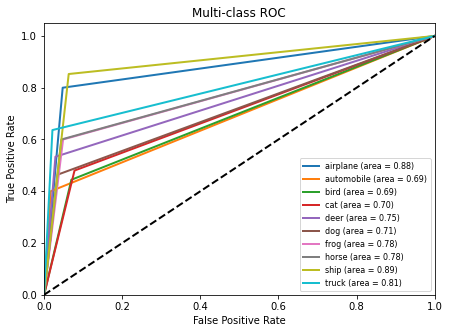

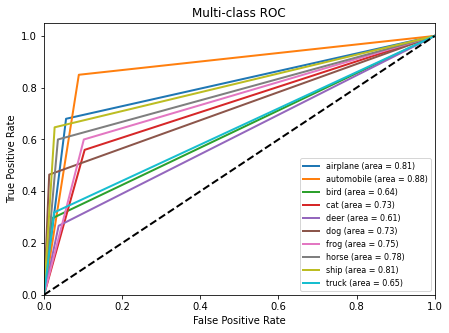

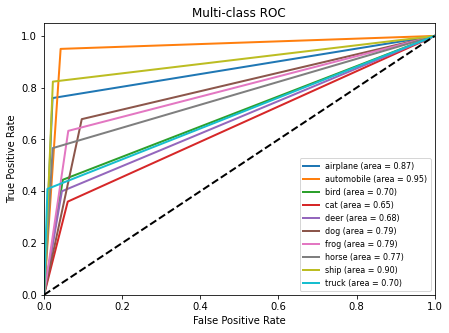

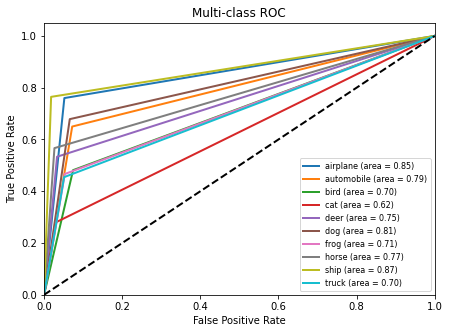

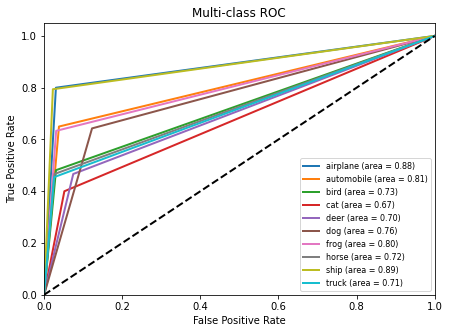

In [ ]:
vocab = dls_train.vocab

results = {'docstring':'Baselines on CIFAR10 at 50 and l00 epochs.'}
num=6
for i in range(num):
    with torch.no_grad():
        _,encoder = create_model('no_pretrain',device)
        model = LM(encoder,numout=10)
        learn = Learner(dls_tune,model,splitter=my_splitter,cbs = [LinearBt(aug_pipelines=aug_pipelines_tune,n_in=3)],wd=0.0)
        learn.num_i = i

    learn.fit(100)

    scores,preds, acc = predict_model(xval,yval,model=model,aug_pipelines_test=aug_pipelines_test,numavg=10)
    #metrics dict will have f1 score, auc etc etc
    metrics = classification_report_wrapper(preds, yval, vocab, print_report=True)
    auc_dict = plot_roc(yval,preds,vocab,print_plot=True)
    metrics['acc'],metrics['auc_dict'],metrics['scores'],metrics['preds'],metrics['xval'],metrics['yval'] = acc,auc_dict,scores,preds,xval,yval

    path = directory + f'/100_epochs_run_{i}'
    torch.save(learn.model.state_dict(),path)

    metrics['model_path'] = path

    print(f'Acc after 50 epochs, on run {i} is: {acc}')

    results[i] = {'100_epochs':metrics,'50_epochs':learn.fifty_epochs_metrics}

save_dict_to_gdrive(d=results,directory=directory,filename='cifar_baselines')


#Load results, and display:

In [ ]:
results=results['baseline']

In [ ]:
from itertools import combinations
from statistics import mean,stdev

def within_ensemble_results(results,key):

    print(f'Results for {key}')

    _results = list(results.values())
    _results = list(combinations(_results,2)) #all pairs of results. So for num=3, will be 3
    lst=[]
    for v in _results:

        print(f"\nAcc of first guy in ensemble is: {v[0]['acc']}")
        print(f"Acc of second guy in ensemble is: {v[1]['acc']}")

        _,acc = predict_ensemble(yval=yval,scores1=v[0]['scores'],scores2=v[1]['scores'])
        #acc = predict_ensemble(v[0]['probs'],v[1]['probs'],dls_valid)

        print(f'Acc of ensemble is:{acc}\n')
        lst.append(acc)

    print(f"mean is: {mean(lst)}")
    print(f"std is: {stdev(lst)}\n")



print('50 nets trained have acc: ')
lst_1 = [results[i]['50_epochs']['acc'] for i in range(num)]
print(lst_1)
print(f'And the mean for 50_epochs nets is: {mean(lst_1)}')

print('100 nets trained have acc: ')
lst_1 = [results[i]['100_epochs']['acc'] for i in range(num)]
print(lst_1)
print(f'And the mean for 100_epochs nets is: {mean(lst_1)}')

fifty_results = {i:results[i]['50_epochs'] for i in range(num)}
hundred_results = {i:results[i]['100_epochs'] for i in range(num)}

within_ensemble_results(fifty_results,key='50_epochs')
within_ensemble_results(hundred_results,key='100_epochs')


50 nets trained have acc: 
[0.56640625, 0.51953125, 0.56640625, 0.5546875, 0.5390625, 0.5703125]
And the mean for 50_epochs nets is: 0.552734375
100 nets trained have acc: 
[0.5859375, 0.56640625, 0.63671875, 0.59375, 0.61328125, 0.58984375]
And the mean for 100_epochs nets is: 0.59765625
Results for 50_epochs

Acc of first guy in ensemble is: 0.56640625
Acc of second guy in ensemble is: 0.51953125
Acc of ensemble is:0.6015625


Acc of first guy in ensemble is: 0.56640625
Acc of second guy in ensemble is: 0.56640625
Acc of ensemble is:0.60546875


Acc of first guy in ensemble is: 0.56640625
Acc of second guy in ensemble is: 0.5546875
Acc of ensemble is:0.58984375


Acc of first guy in ensemble is: 0.56640625
Acc of second guy in ensemble is: 0.5390625
Acc of ensemble is:0.54296875


Acc of first guy in ensemble is: 0.56640625
Acc of second guy in ensemble is: 0.5703125
Acc of ensemble is:0.57421875


Acc of first guy in ensemble is: 0.51953125
Acc of second guy in ensemble is: 0.566406

# Ok, now we write code to evaluate on test set:

Some sanity checks:

In [15]:
test_eq(len(dls_test.train)*bs_test,len(fnames_test)) #sanity check

In [ ]:
load_dict_from_gdrive

In [21]:
results = load_dict_from_gdrive(directory=directory,filename='cifar_baselines')

In [26]:
with torch.no_grad():
    path = results[0]['50_epochs']['model_path']
    _,encoder = create_model('no_pretrain',device)
    model = LM(encoder,numout=10)
    model.load_state_dict(torch.load(path, map_location='cuda:0'))




In [35]:
#sanity check
print(results[0]['50_epochs']['acc'])
_,_,acc = predict_model(xval=xval,yval=yval,model=model,aug_pipelines_test=aug_pipelines_test,numavg=10)
acc

0.56640625


0.5625

In [53]:
for i in range(6):

    for num_epochs in ['50_epochs','100_epochs']:
        
        with torch.no_grad():
            path = results[i][num_epochs]['model_path']
            _,encoder = create_model('no_pretrain',device)
            model = LM(encoder,numout=10)
            model.load_state_dict(torch.load(path, map_location='cuda:0'))


        print(f'On run {i}, for {num_epochs} results are:')

        y,probs,ypred,Acc = predict_whole_model(dls_test,model,aug_pipelines_test,numavg=10,criterion = CrossEntropyLossFlat(),deterministic=False)
        metrics = classification_report_wrapper(ypred, y, dls_test.vocab, print_report=True)
        metrics['acc'],metrics['scores'],metrics['preds'],metrics['y'] = acc,probs,ypred,y
        metrics['acc']=Acc
        print(Acc)

        results[i][num_epochs]['test_results'] = metrics #No need to save for now...

save_dict_to_gdrive(results,directory,'cifar_baselines')


On run 0, for 50_epochs results are:
              precision    recall  f1-score   support

    airplane       0.78      0.44      0.56      1000
  automobile       0.76      0.52      0.62      1000
        bird       0.50      0.43      0.46      1000
         cat       0.43      0.36      0.39      1000
        deer       0.51      0.44      0.47      1000
         dog       0.54      0.46      0.50      1000
        frog       0.62      0.67      0.64      1000
       horse       0.51      0.73      0.60      1000
        ship       0.60      0.81      0.69      1000
       truck       0.53      0.78      0.63      1000

    accuracy                           0.56     10000
   macro avg       0.58      0.56      0.56     10000
weighted avg       0.58      0.56      0.56     10000

0.5641999867558479
On run 0, for 100_epochs results are:
              precision    recall  f1-score   support

    airplane       0.62      0.64      0.63      1000
  automobile       0.71      0.64     

Aside: see commit: 59d4dee (cifar_random_initial_weights_decorrelation.ipynb)

In [54]:
#validation accuracy, BT pretrained
for i in range(6):
    print(main_dict[i]['acc'])

0.58984375
0.6328125
0.59765625
0.62109375
0.62109375
0.62109375


# Baseline results on test set:

In [58]:
for i in range(6):

    for num_epochs in ['50_epochs','100_epochs']:

        acc=results[i][num_epochs]['test_results']['acc']

        print(f'On run {i}, for {num_epochs} test results are: {acc}')

    print('\n')

On run 0, for 50_epochs test results are: 0.5641999867558479
On run 0, for 100_epochs test results are: 0.5514999854564667


On run 1, for 50_epochs test results are: 0.5270999851822853
On run 1, for 100_epochs test results are: 0.5831999868154526


On run 2, for 50_epochs test results are: 0.5386999881267548
On run 2, for 100_epochs test results are: 0.5789999866485596


On run 3, for 50_epochs test results are: 0.564399987757206
On run 3, for 100_epochs test results are: 0.5378999879956246


On run 4, for 50_epochs test results are: 0.4875999876856804
On run 4, for 100_epochs test results are: 0.582099986076355


On run 5, for 50_epochs test results are: 0.5261999872326851
On run 5, for 100_epochs test results are: 0.5894999873638154




#TODO if needed: we can get ensemble test results etc

In [59]:
#metrics = classification_report_wrapper(ypred, y, dls_test.vocab, print_report=True)